# Машинное обучение, DS-поток, осень 2022
# Задание 3.7. Градиентный бустинг

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

from tqdm.notebook import tqdm


from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import fetch_california_housing
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import KFold

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from time import time

sns.set(font_scale=1.8, palette='Set2')
warnings.filterwarnings('ignore')

## Теория

Рассмотрим задачу бинарной классификации, причем $\mathscr{Y} = \{+1, -1\}$. Пусть так же $\widehat{y}$ &mdash; некоторый классификатор, предсказывающий <u><i>степень принадлежности</i></u> классу. При этом решающее правило имеет вид 
 $f(x) = \text{sign}\left(\widehat{y}(x)\right)$.
Рассмотрим логистическую функцию потерь:
$$\mathcal{L}(y, z) = \log \big(1 + \exp(-yz) \big).$$

### Задача 1

Покажите, что задача минимизации по функциям $y(x)$ функционала ошибки $$Q(\widehat{y}) = \sum\limits_{i = 1}^n \mathcal{L}\left(Y_i, y(x_i)\right) \longrightarrow \min_{y(x)}$$ для логистической функции потерь эквивалентна максимизации по $y(x)$ функции правдоподобия в предположении $Y_i \sim Bern(\sigma(y(x_i)))$, где $Y_i \in \{-1, +1 \}$.

### Задача 2

Рассмотрим градиентный бустинг с логистической функцией потерь. Выпишите для градиентного спуска формулу для вектора сдвигов предсказаний и задачу поиска новой базовой модели по их приближению. 

### Задача 3

Предположим, модель градиентного бустинга $\widehat{y}_{t - 1}$ уже построена.
1. Выпишите вид функционала ошибки $Q(\widehat{y}_t) = \sum\limits_{i = 1}^n \mathcal{L}\left(Y_i, \widehat{y}_t(x_i)\right)$ для логистической функции потерь. Одинаковый ли вклад вносят разные объекты в ошибку при построении новой базовой модели $b_t$?
2. Посмотрите на формулу для вектора сдвигов, полученную в предыдущей задаче. Как она выражается через отклики на объектах обучающей выборки? Одинаковый ли вклад вносят разные объекты в формирование вектора сдвигов при построении новой базовой модели $b_t$?
3.  На лекции было показано, что для экспоненциальной функции есть проблема: базовый классификатор может настраиваться только на шумовые объекты. Наблюдается ли такая проблема у логистической функции потерь? Как она ведет себя на объектах с сильно отрицательным, околонулевым, сильно положительным отсупами?

### Задача 4

Рассмотрим градиентный бустинг над решающими деревьями. После построения дерева будем делать перенастройку в листьях дерева.
1. Выпишите оптимизационную задачу для коэффициентов $\gamma_{tj}$ &mdash; новых ответов в листьях.
2. Решите полученную задачу сделав один шаг метода Ньютона из начального приближения $\gamma_{tj} = 0$, что соответствует отсутствию базовой модели $b_t$.


## Практика

### Задача 5

**Внимание!** 

Перед выполнением задачи прочитайте полностью условие. В задаче используются смеси различных моделей с разными гиперпараметрами. Подумайте над тем, какой гиперпараметр как подбирать и на каком множестве. Не забудьте, что на тестовой выборке, по которой делаются итоговые выводы, ничего не должно обучаться.

**Не забывайте делать выводы в каждом пункте!**

In [6]:
housing = fetch_california_housing()
X, y = housing.data, housing.target

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

#### 1.

Повторите исследование, проведенное в задаче 3 предыдущего домашнего задания, используя градиентный бустинг из `sklearn`. Сравните полученные результаты со случайным лесом. 

Вкратце опишем задания:
1. Посмотрите, как меняется качество модели в зависимости от значений гиперпараметров и сделайте выводы по результатам. Гиперпараметры:
    * количество деревьев (`n_estimators`) [от 1 до 400];
    * максимальная глубина дерева (`max_depth`) [от 3 до 15];
    * скорость обучения (`learning_rate`), поясните также смысл этого параметра.
2. Запустите модель три раза с параметрами по-умолчанию. Объясните результаты.
3. Подберите оптимальные гиперпараметры, рассмотренные в первом пункте и зафиксируйте их.
4. Исследуйте зависимость метрики от количества признаков, по которым происходит разбиение в вершине дерева. Объясните результаты.

*Замечания.*
* В качестве основы можно использовать как свое решение предыдущего задания, так и выложенное на Вики. В большинстве случаев нужно только заменить `RandomForestRegressor` на `GradientBoostingRegressor`.
* При сравнении методов по одинаковым свойствам желательно рисовать результаты на одном графике.
* Обратите внимание на метод `staged_predict` у `GradientBoostingRegressor`. Он позволяет получить "кумулятивные" предсказания, то есть по первым $t$ деревьям по всем значениям $t$.
* При желании, границы рассмотрения значений гиперпараметров можно увеличить.
* При подборе гиперпараметров при помощи рандомизированного поиска проводите достаточное количество на большой сетке параметров &mdash; как минимум 50. Даже если долго обучается.

*1. Зависимость качества модели от гиперпараметров*

In [8]:
md_grid = np.arange(3, 16)
mses = []

for md in md_grid:
    m = GradientBoostingRegressor(max_depth=md)
    m.fit(X_train, y_train)
    mse = mean_squared_error(y_test, m.predict(X_test))
    mses.append(mse)

mses = np.array(mses)

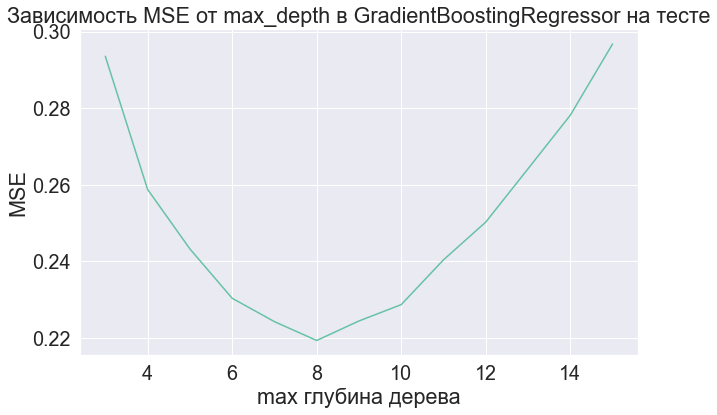

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(md_grid, mses)
plt.xlabel('max глубина дерева')
plt.ylabel('MSE')
plt.title('Зависимость MSE от max_depth в GradientBoostingRegressor на тесте');

In [10]:
m = GradientBoostingRegressor(n_estimators=400)
m.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=400)

In [11]:
cum_preds = np.array(list(m.staged_predict(X_test)))

In [12]:
cum_mse = [mean_squared_error(y_test, pred) for pred in cum_preds]

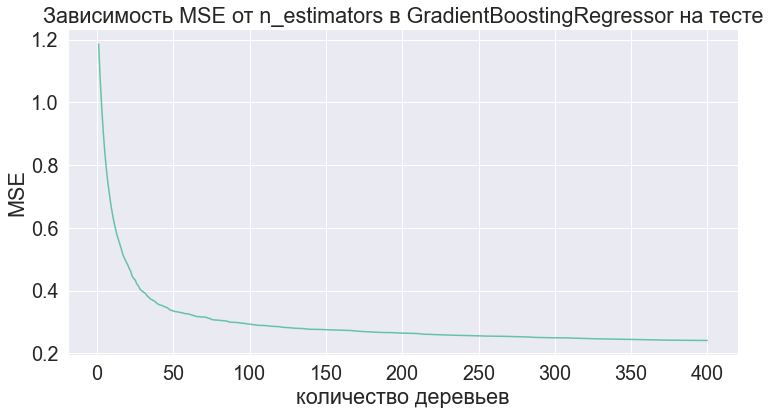

In [13]:
nestimators_grid = np.arange(1, 401)
plt.figure(figsize=(12, 6))
plt.plot(nestimators_grid, cum_mse)
plt.xlabel('количество деревьев')
plt.ylabel('MSE')
plt.title('Зависимость MSE от n_estimators в GradientBoostingRegressor на тесте');

In [14]:
lr_grid = np.arange(1e-6, 1, 0.01)
mses = []

for lr in lr_grid:
    m = GradientBoostingRegressor(learning_rate=lr)
    m.fit(X_train, y_train)
    mse = mean_squared_error(y_test, m.predict(X_test))
    mses.append(mse)

mses = np.array(mses)

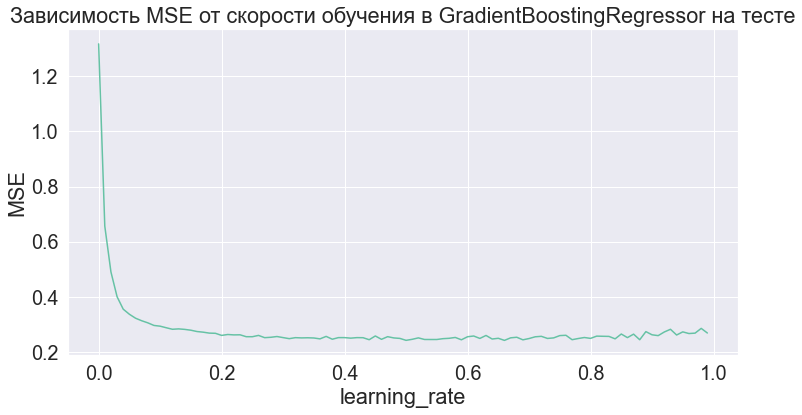

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(lr_grid, mses)
plt.xlabel('learning_rate')
plt.ylabel('MSE')
plt.title('Зависимость MSE от скорости обучения в GradientBoostingRegressor на тесте');

In [16]:
print('Оптимальный learning rate', round(lr_grid[np.argmin(mses)], 2))

Оптимальный learning rate 0.66


***Вывод*** *1) В градиентном спуске меньшую ошибку дают деревья небольшой глубины. Видим по графику, что есть оптимальное значение глубины = 8, а более глубокие деревья очень сильно повышают ошибку на тесте - это означает переученность модели на трейне (низкое bias, большой variance). Поэтому используют неглубокие деревья, которые отдельно имеют высокий bias, но после итеративной оптимизации он будет ниже.*

*2) В Градиентном бустинге, как в одной из моделей ансамблей, качество модели улучашается при увеличении количества базовых моделей. Это происходит потому, что уменьшается variance. После определенного значения качество особо не улучшается, поэтому можно зафиксировать предельное значение*

*3) Смысл learning rate в градиентном бустинге - борьба с переобучением. Присутствие этого параметра означает, что каждый базовый алгоритм вносит относительно небольшой вклад во всю композицию. Он также подбирается эмпирически. На текущих данных при дефолтных параметрах это ~0.5*



*2. Cлучайность предсказания*

In [17]:
for i in range(3):
    model = GradientBoostingRegressor()
    model.fit(X_train, y_train)
    print(f'MSE на тесте = {mean_squared_error(y_test, model.predict(X_test))}')


MSE на тесте = 0.2935484140024643
MSE на тесте = 0.2935476555015737
MSE на тесте = 0.2935476555015737


***Вывод***: *Признакм всегда случайным образом переставляются при каждом сплите. Следовательно, наилучший найденный сплит может различаться даже при одинаковых обучающих данных и max_features=n_features. Чтобы получить детерминированное поведение во время подбора, нужно зафиксировать параметр `random_state`*

*3) Подбор оптимальных параметров*

*При подборе нескольких гиперпараметров рекомендуется использовать случайный поиск* 

In [18]:
rnd_boosting_gridsearch = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_distributions={
        'learning_rate': np.linspace(0.1, 0.8, 50),
        'n_estimators': np.arange(50, 100),
        'max_depth': [3, 4, 5, 6, 8, 9, 10]
    },
    cv=5,
    n_jobs=-2,
    n_iter=50,
    random_state=42
)

In [19]:
rnd_boosting_gridsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=50, n_jobs=-2,
                   param_distributions={'learning_rate': array([0.1       , 0.11428571, 0.12857143, 0.14285714, 0.15714286,
       0.17142857, 0.18571429, 0.2       , 0.21428571, 0.22857143,
       0.24285714, 0.25714286, 0.27142857, 0.28571429, 0.3       ,
       0.31428571, 0.32857143, 0.34285714, 0.35714286, 0.37142857,
       0.38571429...
       0.6       , 0.61428571, 0.62857143, 0.64285714, 0.65714286,
       0.67142857, 0.68571429, 0.7       , 0.71428571, 0.72857143,
       0.74285714, 0.75714286, 0.77142857, 0.78571429, 0.8       ]),
                                        'max_depth': [3, 4, 5, 6, 8, 9, 10],
                                        'n_estimators': array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
       84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 9

In [20]:
rnd_boosting_gridsearch.best_estimator_

GradientBoostingRegressor(learning_rate=0.15714285714285714, max_depth=6,
                          n_estimators=85, random_state=42)

*Качество оптимальной модели:*

In [21]:
print('Train MSE {:.4f}'.format(
    mean_squared_error(rnd_boosting_gridsearch.predict(X_train), y_train)
))
print('Test accuracy {:.4f}'.format(
    mean_squared_error(rnd_boosting_gridsearch.predict(X_test), y_test)
))

Train MSE 0.1079
Test accuracy 0.2260


In [22]:
rnd_boosting_gridsearch.best_params_

{'n_estimators': 85, 'max_depth': 6, 'learning_rate': 0.15714285714285714}

***Вывод*** *Поиск гиперпараметров по сетке дал предсказуемый результат - max_depth и learning_rate стали ниже дефолтных параметров. Оба эти параметра уменьшаются для исключения переобучения дерева, то есть для снижения variance общего предсказания*

*4. Зависимость метрики от количества признаков, по которым ищутся пороги*

In [23]:
features_grid = np.arange(1, X_train.shape[1] + 1) / X_train.shape[1]

mses_f = []

for f_p in features_grid:
    m = GradientBoostingRegressor(**rnd_boosting_gridsearch.best_params_, subsample=f_p)
    m.fit(X_train, y_train)
    mse = mean_squared_error(y_test, m.predict(X_test))
    mses_f.append(mse)

mses_f = np.array(mses_f)

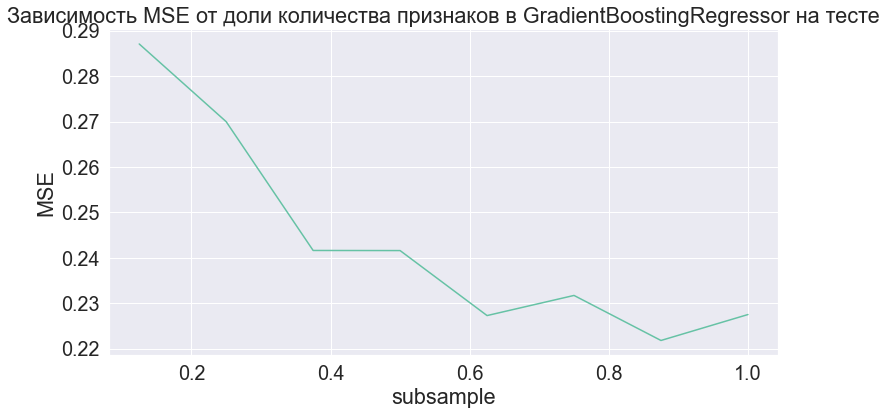

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(features_grid, mses_f)
plt.xlabel('subsample')
plt.ylabel('MSE')
plt.title('Зависимость MSE от доли количества признаков в GradientBoostingRegressor на тесте');

In [25]:
print('Оптимальный subsamlpe', round(features_grid[np.argmin(mses_f)], 2))

Оптимальный subsamlpe 0.88


***Вывод***: *Чем меньше доля признаков, которые используются для разбиения, тем у каждого отдельного дерева выше смещение.  Теоретически доказывается, что градиентный бустинг дает лучшее качество, если используются слабые базовые модели с высоким смещением, но низким varience. Этот гиперпараметр обычно берут по правилу "корень из числа всех признаков для классификации и треть признаков для регрессии". Но это только "rule of thumb", этот параметр надо так же подбирать по сетке под конкретные данные. По моему исследованию минимальная ошибка предсказания достигается при доли количества признаков около 0.8. Зафиксирую этот параметр.*

*Итого получили оптимальные гиперпараметры для градиентного бустинга:*

In [26]:
optimal_params = {'subsample': features_grid[np.argmin(mses_f)], **rnd_boosting_gridsearch.best_params_}
optimal_params

{'subsample': 0.875,
 'n_estimators': 85,
 'max_depth': 6,
 'learning_rate': 0.15714285714285714}

In [27]:
best_gb_model = GradientBoostingRegressor(**optimal_params)
best_gb_model.fit(X_train, y_train)

print('Train MSE {:.4f}'.format(
    mean_squared_error(best_gb_model.predict(X_train), y_train)
))
print('Test accuracy {:.4f}'.format(
    mean_squared_error(best_gb_model.predict(X_test), y_test)
))

Train MSE 0.1107
Test accuracy 0.2277


**2.**

Проведите сравнение градиентного бустинга и случайного леса с оптимальными гиперпараметрами, подобранными ранее, по производительности, в рамках которого выполните следующие действия.
* Замерьте время обучения данных моделей.
* Замерьте время построения предсказания для каждого объекта тестовой выборки. Постройте гистограмму, посчитайте среднее время и предсказательный интервал (возьмите выборочные квантили).
* Сравните фактическую глубину деревьев и количество листьев в композициях с помощью гистограмм. Посчитайте также среднее значение указанных характеристик. Используйте методы `get_depth()` и `get_n_leaves()` у решающего дерева.

In [64]:
optimal_params

{'subsample': 0.875,
 'n_estimators': 85,
 'max_depth': 6,
 'learning_rate': 0.15714285714285714}

In [28]:
best_rf_model = RandomForestRegressor(max_depth=24, n_estimators=48, max_features=2)

In [29]:
%%time
best_rf_model.fit(X_train, y_train)

CPU times: user 1.6 s, sys: 41.9 ms, total: 1.65 s
Wall time: 1.65 s


RandomForestRegressor(max_depth=24, max_features=2, n_estimators=48)

In [30]:
%%time
best_gb_model.fit(X_train, y_train)

CPU times: user 5.55 s, sys: 25.1 ms, total: 5.57 s
Wall time: 5.57 s


GradientBoostingRegressor(learning_rate=0.15714285714285714, max_depth=6,
                          n_estimators=85, subsample=0.875)

*Градиентный бустинг учится медленней. Это ожидаемо, так как обучение базовых моделей последовательное, а в случайном лесу - параллельное.*

In [31]:
X_test_separated = X_test.reshape(X_test.shape[0], 1, -1)

In [32]:
gb_predict_times = []

for test_elem in X_test_separated:
    start = time()
    best_gb_model.predict(test_elem)
    end = time()
    gb_predict_times.append(end - start)

In [33]:
rf_predict_times = []

for test_elem in X_test_separated:
    start = time()
    best_gb_model.predict(test_elem)
    end = time()
    rf_predict_times.append(end - start)

In [34]:
gb_predict_times = np.array(gb_predict_times)
rf_predict_times = np.array(rf_predict_times)

mean_gb = gb_predict_times.mean()
mean_rf = rf_predict_times.mean()

gb_q1, gb_q2 = np.quantile(gb_predict_times, 0.25), np.quantile(gb_predict_times, 0.75)
rf_q1, rf_q2 = np.quantile(rf_predict_times, 0.25), np.quantile(rf_predict_times, 0.75)

*Для информативности гистограммы уберем выбросы по времени*

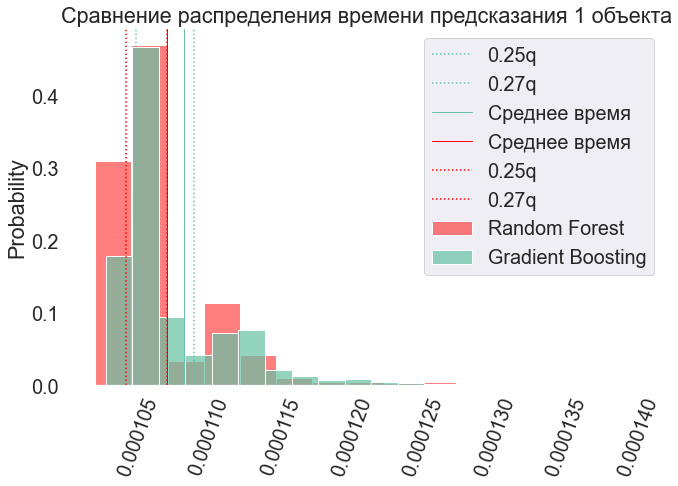

In [35]:
plt.figure(figsize=(10, 6))
sns.histplot(rf_predict_times[np.where(rf_predict_times < 0.00014)], alpha=0.5, bins=15, 
             stat='probability', color='r', label='Random Forest')
sns.histplot(gb_predict_times[np.where(gb_predict_times < 0.00014)], alpha=0.7, bins=20, 
             stat='probability',  label='Gradient Boosting')
plt.axvline(gb_q1, label='0.25q', ls=':')
plt.axvline(gb_q2, label='0.27q', ls=':')

plt.axvline(mean_gb, label='Среднее время', lw=1)
plt.axvline(mean_rf, color='r', label='Среднее время', lw=1)


plt.axvline(rf_q1, color='r', label='0.25q', ls=':')
plt.axvline(rf_q2, color='r', label='0.27q', ls=':')

plt.gca().set_facecolor('white')
plt.tight_layout()
plt.xticks(rotation=70)
plt.title('Сравнение распределения времени предсказания 1 объекта')
plt.legend();

*Видим, что предсказание бустинга в среднем быстрее.*

*Фактичекая глубина везде одна - это max_depth в каждой модели*

In [36]:
np.all([estimator.get_depth() == best_rf_model.max_depth for estimator in best_rf_model.estimators_])

True

In [37]:
np.all([estimator[0].get_depth() == best_gb_model.max_depth for estimator in best_gb_model.estimators_])

True

*A вот количество листьев у деревьев отличается*

In [38]:
rf_n_leaves = [estimator.get_n_leaves() for estimator in best_rf_model.estimators_]
mean_rf_leaves = np.mean(rf_n_leaves)

In [39]:
gb_n_leaves = [estimator[0].get_n_leaves() for estimator in best_gb_model.estimators_]
mean_gb_leaves = np.mean(gb_n_leaves)

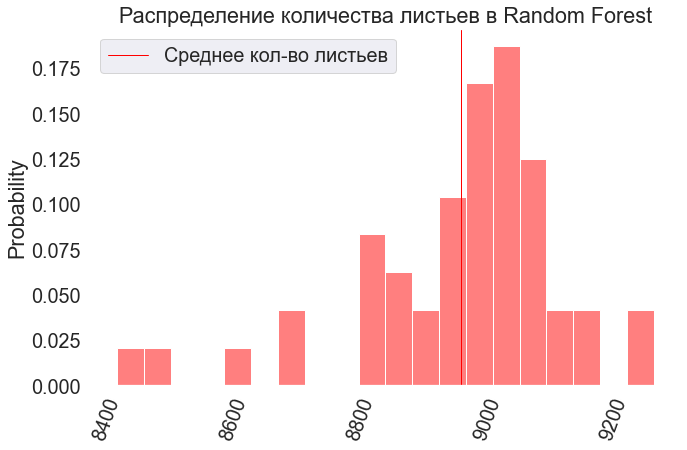

In [70]:
plt.figure(figsize=(10, 6))
sns.histplot(rf_n_leaves, alpha=0.5, bins=20, stat='probability', color='r')

plt.axvline(mean_rf_leaves, color='r', label='Среднее кол-во листьев', lw=1)

plt.gca().set_facecolor('white')
plt.tight_layout()
plt.xticks(rotation=70)
plt.title('Распределение количества листьев в Random Forest')
plt.legend();

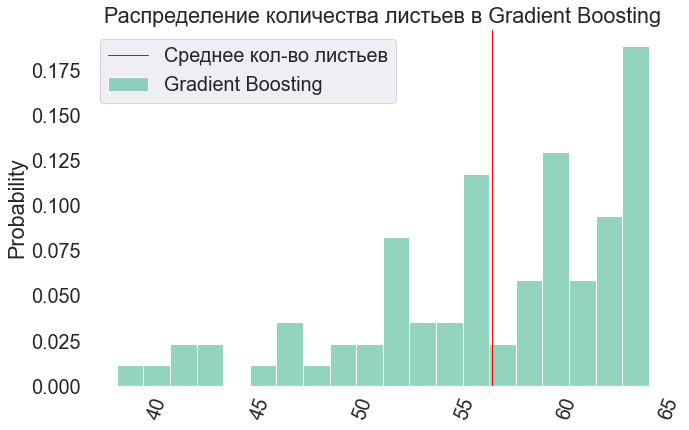

In [71]:
plt.figure(figsize=(10, 6))
sns.histplot(gb_n_leaves, alpha=0.7, bins=20, stat='probability',  label='Gradient Boosting')
plt.axvline(mean_gb_leaves, label='Среднее кол-во листьев', lw=1, c='r')

plt.gca().set_facecolor('white')
plt.tight_layout()
plt.xticks(rotation=70)
plt.title('Распределение количества листьев в Gradient Boosting')
plt.legend();

Для случайного леса распределение более симметричное так как мы не упираемся в максимально возможное число листьев. У бустинга количество листьев имеет достаточно скошенное распределение и не превышает 64. 

#### 3. 

Выберите самый значимый признак согласно `feature_importances_`. Визуализируйте работу бустинга, обученного только на одном этом признаке.

Для этого рассмотрите процесс построения бустинга для первых 10 итераций. При визуализации требуется для каждой итерации нарисовать:
* предсказания новой базовой модели и выборку, на которой эта базовая модель обучается;
* предсказания текущей композиции и исходную обучающую выборку. 

Пример графиков смотрите в лекции в разделе бустинг в задаче регресии.

In [56]:
imp_feature_train = X_train[:, np.argmax(best_gb_model.feature_importances_)].reshape(-1, 1)

best_gb_model.fit(imp_feature_train, y_train)

GradientBoostingRegressor(learning_rate=0.15714285714285714, max_depth=6,
                          n_estimators=85, subsample=0.875)

In [57]:
cum_preds = np.array(list(best_gb_model.staged_predict(imp_feature_train)))

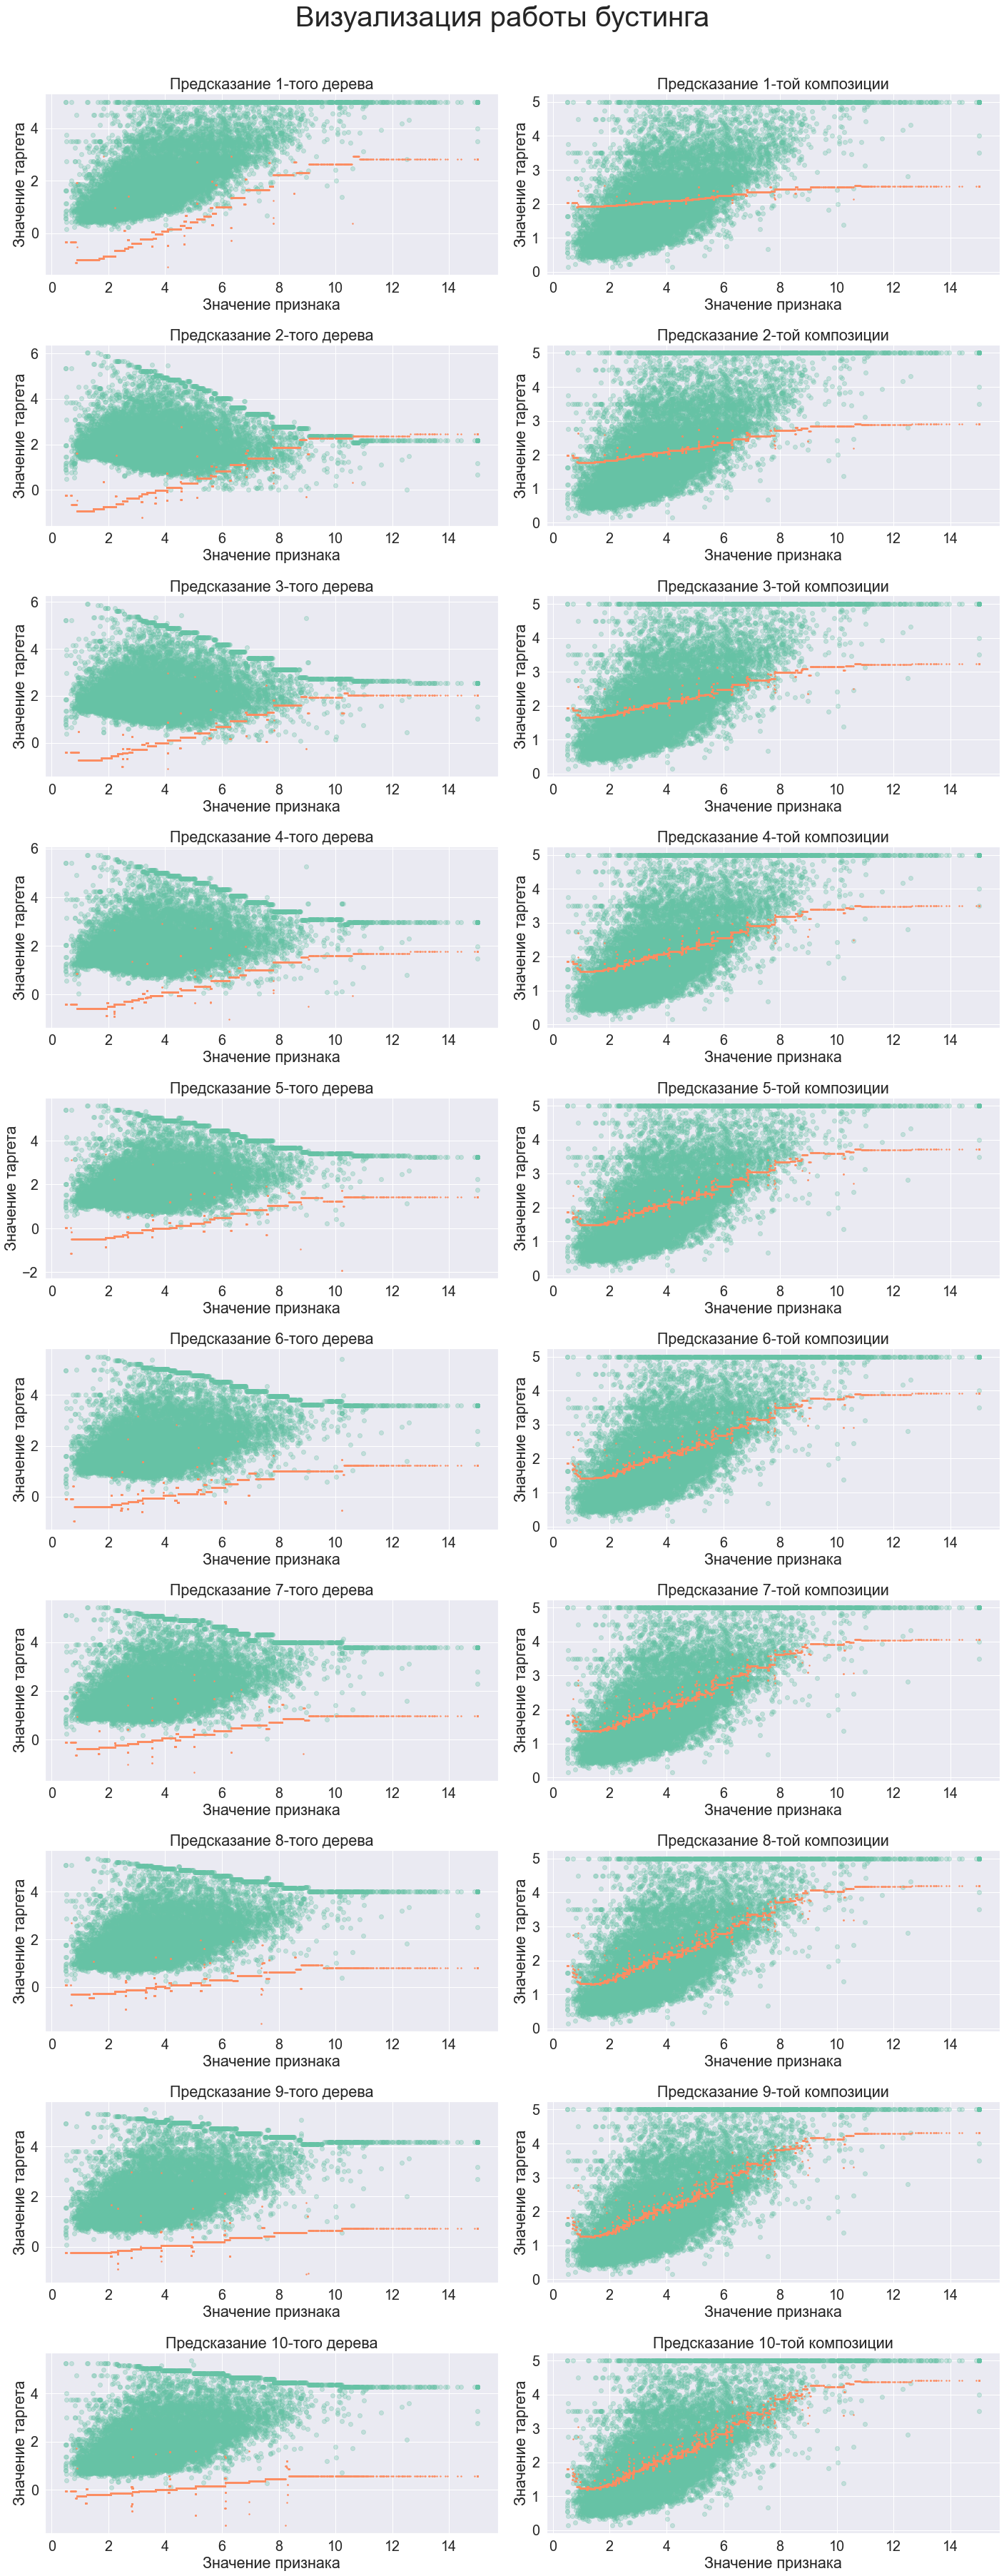

In [78]:
fig, axs = plt.subplots(10, 2, figsize=(20, 50))

residuals = y_train.copy()

for i in range(10):
    base_model_pred = best_gb_model.estimators_[i][0].predict(imp_feature_train)
    axs[i][0].scatter(imp_feature_train.reshape(-1), residuals, alpha=0.3)
    axs[i][0].scatter(imp_feature_train.reshape(-1), base_model_pred, s=2)
    axs[i][0].set_title(f'Предсказание {i+1}-того дерева')
    axs[i][0].set_xlabel('Значение признака')
    axs[i][0].set_ylabel('Значение таргета')
    
    axs[i][1].scatter(imp_feature_train.reshape(-1), y_train, alpha=0.3)
    axs[i][1].scatter(imp_feature_train.reshape(-1), cum_preds[i], s=2)
    axs[i][1].set_title(f'Предсказание {i+1}-той композиции')
    axs[i][1].set_xlabel('Значение признака')
    axs[i][1].set_ylabel('Значение таргета')
    
    residuals = np.abs(y_train - base_model_pred)
    
plt.suptitle('Визуализация работы бустинга', fontsize=40, y=1.005)
plt.tight_layout();

*По графику видно, что с возрастанием числа деревьев композици всё лучше приближает обучающую выборку*

Как получается выборка, на которой обучается новая базовая модель в данном случае и в общем случае? 

*Это разница между таргетом и предсказанием. В данном случае она еще умножается на скорость обучения.* 

#### 4.

Параметр `init` у класса `GradientBoostingRegressor` задает модель, выполняющую начальные предсказания, с которых стартует построение ансамбля. Какая начальная модель используется по умолчанию?

In [59]:
best_gb_model.init_

DummyRegressor()

*Это знаачит, что в качестве первого начального приближения возьмется средний таргет.*

Обучите градиентный бустинг на решающих деревьях, у которого в качестве инициализирующей модели используется линейная регрессия. Для этого в качестве параметра `init` передайте модель ридж-регрессии `Ridge`, которая должна быть инициализирована, но необучена. 

Подберите оптимальные гиперпараметры такой композиции. Как вы будете подбирать гиперпараметр ридж-регрессии? Улучшилось ли качество модели на тестовой выборке?

*Замечания.* 

1. Для настройки `alpha` в `Ridge`-модели внутри `GradientBoostingRegressor` вам может помочь метод `get_params()` у бустинга.
2. Не забывайте, что у бустинга тоже есть параметр `alpha`, не перепутайте их.

In [81]:
ridge_pipeline = Pipeline([('scaler', StandardScaler()), 
                           ('ridge', Ridge())])

gb_ridge_regressor = GradientBoostingRegressor(
    n_estimators=best_gb_model.n_estimators, init=ridge_pipeline, random_state=42
)

In [82]:
gb_ridge_gridsearch = RandomizedSearchCV(
    estimator=gb_ridge_regressor, 
    param_distributions={
        'max_depth': np.arange(3, 20), 
        'learning_rate': np.linspace(0.05, 0.5, 300),
        'init__ridge__alpha': np.logspace(-3, 3, 501)
    },
    cv=5,
    verbose=1,
    n_jobs=-2,
    n_iter=50,
    random_state=3,
)

gb_ridge_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=GradientBoostingRegressor(init=Pipeline(steps=[('scaler',
                                                                             StandardScaler()),
                                                                            ('ridge',
                                                                             Ridge())]),
                                                       n_estimators=85,
                                                       random_state=42),
                   n_iter=50, n_jobs=-2,
                   param_distributions={'init__ridge__alpha': array([1.00000000e-03, 1.02801630e-03, 1.05681751e-03, 1.08642562e-03,
       1.11686325e-03, 1.14815362e-03, 1.18032064e-03, 1.21338885e-03...
       0.4638796 , 0.46538462, 0.46688963, 0.46839465, 0.46989967,
       0.47140468, 0.4729097 , 0.47441472, 0.47591973, 0.47742475,
       0.47892977, 0.48043478, 0.4819398 , 0.48344482, 0.48494983,
       0.48645485, 0.487

*Оптимальные значения гиперпараметров:*

In [83]:
gb_ridge_gridsearch.best_params_

{'max_depth': 9,
 'learning_rate': 0.1568561872909699,
 'init__ridge__alpha': 47.863009232263806}

*Оптимальное качество модели по MSE:*

In [86]:
print(f'MSE на тесте: {mean_squared_error(y_test, gb_ridge_gridsearch.predict(X_test)):.5f}')

MSE на тесте: 0.23073


*Вывод: в данном случае улучшить качество, взяв другую первичную модель, не удалось, хотя теоретически это может произойти, так как алгоритм жадный. Но видимо особого вклада в понижение ошибки это не даст (по сравнению с подбробом гиперпараметров), поэтому это делают редко.* 

#### 5. 

Рассмотрим модели смеси градиентного бустинга $\widehat{y}_{gb}$ и случайного леса $\widehat{y}_{rf}$ с оптимальными гиперпараметрами, подобранными ранее, в виде
$$\widehat{y}(x) = w \widehat{y}_{gb}(x) +  (1-w) \widehat{y}_{rf}(x),$$
где $w \in [0, 1]$ &mdash; коэффициент усреднения. Подберите оптимальное значение гиперпараметра $w$ и выведите его. Удалось ли добиться улучшения качества на тестовой выборке?

In [90]:
model_gb = GradientBoostingRegressor(
    **optimal_params, random_state=42
)
model_rf = RandomForestRegressor(
    n_estimators=200, max_depth=26, random_state=42
)

In [93]:
preds_gb = cross_val_predict(model_gb, X_train, y_train, cv=10)
preds_rf = cross_val_predict(model_rf, X_train, y_train, cv=10)

In [95]:
mse_values = []
w_values = np.linspace(0, 1, 101)

for w in w_values:
    predictions = w * preds_gb + (1 - w) * preds_rf
    mse_values.append(mean_squared_error(y_train, predictions))

In [96]:
best_w = w_values[np.argmin(mse_values)]
print(f'Лучшее значение коэффициента усреднения: {best_w:.3f}')

Лучшее значение коэффициента усреднения: 0.840


In [98]:
model_gb.fit(X_train, y_train)
model_rf.fit(X_train, y_train)

preds_gb = model_gb.predict(X_test)
preds_rf = model_rf.predict(X_test)

predictions = w * preds_gb + (1 - w) * preds_rf
mse_test = mean_squared_error(y_test, predictions)
print(f'MSE на тесте: {mse_test:.5f}')

MSE на тесте: 0.22911


Использование смеси градиентного бустинга и случайного леса со значением  𝑤=0.84  дает такой же результат, как лучшая модель градиентного бустинга без инициализации.

**6.**

Сделайте итоговые выводы.

*Подбором гиперпараматров в градиентном бустинге можно добиться лучшего качества предсказания, чем для модели случайного леса. Смесь случайного леса и бустинга или выбор другой первой базовой модели не дают особого улучшения качества.*